# In case of using colab 
Remember to connect to your drive and upload the dataset

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/

# Using YOLOv7 for car detection
To train a neural network for object detection is required to download a dataset. In this case we are going to use the car-detection dataset for vehicle detection. To download the file is required to go to Kaggle and download the file in YOLO v7 PyTorch format. 


[car-detection-dataset](https://www.kaggle.com/code/balraj98/yolo-v5-car-object-detection/input)



# Download YOLOv7 Repository
Then we need the source code to build and train the neural network. You may need to install the dependencies required for this repository. 

In [1]:
# !git clone https://github.com/LuisCossioUOH/HandsOnDetection.git
# %cd HandsOnDetection
# !pip install -r requirements.txt ### UNCOMMENT IF NOT ENOUGH DEPENDENCIES


/home/luis/2024/Hands_on/yolov7


In [3]:
import os
import cv2
import math
import yaml
import time
import random
import logging

import numpy as np
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
from argparse import Namespace
import matplotlib.pyplot as plt


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data

from torch.cuda import amp

import evaluation  

from models.yolo import Model
from utils.autoanchor import check_anchors
from utils.datasets import create_dataloader, LoadImagesAndLabels, letterbox

from utils.general import labels_to_class_weights, init_seeds, fitness, \
    check_file, check_img_size, set_logging, one_cycle, colorstr, non_max_suppression
from utils.google_utils import attempt_download
from utils.loss import ComputeLoss, ComputeLossAuxOTA
from utils.torch_utils import ModelEMA, intersect_dicts, torch_distributed_zero_first
from utils.wandb_logging.wandb_utils import WandbLogger
from utils.plots import color_list, plot_one_box, plot_images,output_to_target

from train_example import training_session, get_files_datasets, create_ellipse_dataloaders


logger = logging.getLogger(__name__)
%matplotlib inline

# Setting up training
Here we have several settings for the training. Nonetheless we recommend using the default settings and perhaps change the batch-size to manga CUDA out of memory error if you are using the GPU. Later you can learn what does what. 


In [6]:
opt = Namespace()

##### PATH SETTINGS ################
opt.data = 'data/vehicle.yaml'
opt.cfg = 'cfg/training/yolov7-vehicle.yaml'
opt.hyp = 'data/hyp.scratch.custom.yaml'
opt.project = 'train_car_detection'
opt.data, opt.cfg, opt.hyp = check_file(opt.data), check_file(opt.cfg), check_file(opt.hyp)  # check files
assert len(opt.cfg) or len(opt.weights), 'either --cfg or --weights must be specified'
opt.name = 'yolov7-6e'
opt.save_dir = 'runs'
##### Dataset info ####################################
opt.update_dataset = True
opt.data_train ='/home/luis/2024/Hands_on/archive/data/images' # 
opt.names_classes = ['vehicle'] 
opt.nc = 1
opt.single_cls = True

##### HYPER-PARAMS OPTIMIZATION ########################
opt.weights = ''# '/home/luis/2022/yolov7/weights/yolov7-e6_training.pt'
opt.batch_size = 3
opt.device = 'cuda' if torch.cuda.is_available() else 'cpu'
opt.multi_scale = False
opt.epochs = 30
opt.img_size = [480, 480]
opt.img_size.extend([opt.img_size[-1]] * (2 - len(opt.img_size)))  # extend to 2 sizes (train, test)
opt.adam = True
opt.accumulate = 2
########################################################

#### DEFAULT SETTING (DON'T CHANGE)
opt.seed = 333
opt.save_interval = 10
opt.world_size = 1
opt.rect = True
opt.global_rank = -1
set_logging(opt.global_rank)
opt.resume= False
opt.workers = 8
opt.cache_images = False
opt.label_smoothing = 0.0
opt.bbox_interval = -1
opt.save_period = -1
opt.noautoanchor = False
opt.nosave = False
opt.notest = False
opt.v5_metric = False
########################################################

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
with open(opt.hyp) as f:
    hyp = yaml.load(f, Loader=yaml.SafeLoader)  # load hyps

logger.info(opt)

logger = logging.getLogger(__name__)

# Train

Namespace(accumulate=2, adam=True, batch_size=3, bbox_interval=-1, cache_images=False, cfg='cfg/training/yolov7-vehicle.yaml', data='data/vehicle.yaml', data_train='/home/luis/2024/Hands_on/archive/data/images', device='cuda', epochs=30, global_rank=-1, hyp='data/hyp.scratch.custom.yaml', img_size=[480, 480], label_smoothing=0.0, multi_scale=False, name='yolov7-6e', names_classes=['vehicle'], nc=1, noautoanchor=False, nosave=False, notest=False, project='train_car_detection', rect=True, resume=False, save_dir='runs', save_interval=10, save_period=-1, seed=333, single_cls=True, update_dataset=True, v5_metric=False, weights='', workers=8, world_size=1)



## Understanding the dataset

![image_dataset](https://sebastianraschka.com/images/blog/2022/datapipes/card.png)

A key component in the training of a neural network is the dataset. Pytorch uses Dataset objects to fetch data from files. For Object detection each dataset contains the image and a corresponding file with the location of objects in said image, in this case a .txt file.
To add further customization and mini-batch training capabilities we use Dataloaders. Dataloaders are basically a wrapper of the dataset with these extra functionalities. 


Datasets hace indexed each file in the dataset and only need a precise index to give the corresponding image and label. 



## Testing the dataset

In [7]:
ts = training_session(hyp, opt, device)
max_stride = ts.max_stride
dataset_train, dataloader_train, dataloader_test, imgsz = get_files_datasets(hyp, opt, ts.data_dict,max_stride)

hyperparameters: lr0=0.001, lrf=0.001, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.2, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.0, copy_paste=0.0, paste_in=0.0, loss_ota=1

                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1      7040  models.common.Conv                      [12, 64, 3, 1]                
  2                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  3                -1  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  4                -2  1      8320  models.comm


val: Scanning '/home/luis/2024/Hands_on/archive/data/labels.cache' images and la


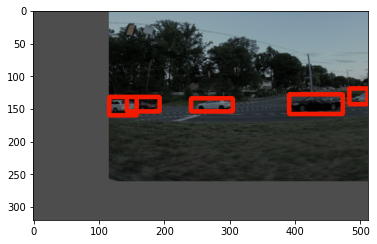

In [11]:
index_item = np.random.randint(len(dataset_train))
imgs, labels, paths, _ = dataset_train[index_item]
img = imgs.cpu().numpy().transpose(1,2,0)

imgs = imgs[None]
imgs = imgs.to(device, non_blocking=True).float() / 255.0  # uint8 to float32, 0-255 to 0.0-1.0
colors = np.array([[0.95,0.1,0.0],[0.8,0.4,0.2],[0.1,1.0,0.1]]) * 255
thickness=6
dim_img = np.array(list(reversed(img.shape[:2])))
for box in labels:
    pt1 = np.array(box[2:4] * dim_img,dtype=np.int32) 
    dims = np.array(box[4:6] * dim_img,dtype=np.int32)  
    pt2 = pt1 + dims//2
    pt1 = pt1 - dims//2
    c_point = colors[int(box[1])]
    img = cv2.rectangle(img.copy(),pt1.tolist(),pt2.tolist(),color=c_point,thickness=thickness)

plt.imshow(img)


### Difference with the dataloader

In [12]:
for (imgs, targets, paths, _)  in dataloader_train:
    print(imgs.size())
    print(targets)
    print(paths)
    break

torch.Size([3, 3, 320, 512])
tensor([[0.00000, 0.00000, 0.63012, 0.60317, 0.05087, 0.06321]])
['/home/luis/2024/Hands_on/archive/data/images/vid_4_1000.jpg', '/home/luis/2024/Hands_on/archive/data/images/vid_4_26120.jpg', '/home/luis/2024/Hands_on/archive/data/images/vid_4_26140.jpg']


In [13]:
del ts, dataloader_train, dataset_train, dataloader_test, imgsz

# Training

In its simplest form the training pipeline will consist of one iteration across every sample. This involves only a simple cycle across the dataloader.


The process consist of 5 operations:
1. The optimizer grads are set to 0. This is done because each iteration the gradients receive more gradient and failing to set it to 0 at the beginning of the iteration will cause the gradient to accumulate across all the training.  
2. The network produce a prediction for each image in the batch
3. A criterion function is used to calculate the loss/error of the prediction. In this case the loss is composed of a L2 distance loss and a classification loss (cross-entropy)
4. The gradient is propagated backward in the network updating the gradients of each neuron. 
5. The optimizer updates the weights based on the gradients. 



In this case the train function is a little more complicated. It's basically a shrunken down version of the training pipeline for the original YOLOv7, but still rather complex to account for several steps. Take a look and try to find each component. 



## Basic Problem: Elipse detection
You can experiment with the HYPER-PARAMS OPTIMIZATION settings. 

In [15]:
########################################################
##### Dataset info ####################################
########################################################
opt.update_dataset = True
opt.data_train ='' # 
opt.nc = 3
opt.names_classes = ['ellipse{:d}'.format(i) for i in range(opt.nc)] # ['vehicle'] #['ripe','unripe','green']
opt.single_cls = opt.nc==1

##### HYPER-PARAMS OPTIMIZATION ########################
opt.weights = ''# '/home/luis/2022/yolov7/weights/yolov7-e6_training.pt'
opt.batch_size = 8
opt.device = 'cuda' if torch.cuda.is_available() else 'cpu'
opt.multi_scale = False
opt.epochs = 30
opt.img_size = [192, 192]
opt.img_size.extend([opt.img_size[-1]] * (2 - len(opt.img_size)))  # extend to 2 sizes (train, test)
opt.adam = True
opt.accumulate = 1
########################################################

In [17]:
ts = training_session(hyp, opt, device)
max_stride = ts.max_stride
dataset_ellipse, dataloader_ellipse, dataloader_ellipse_test, imgsz = create_ellipse_dataloaders(opt.img_size,
                                                                                             opt.batch_size,
                                                                                             max_stride,
                                                                                             workers=opt.workers)


hyperparameters: lr0=0.001, lrf=0.001, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.2, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.0, copy_paste=0.0, paste_in=0.0, loss_ota=1
Overriding model.yaml nc=1 with nc=3

                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1      7040  models.common.Conv                      [12, 64, 3, 1]                
  2                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  3                -1  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  4       

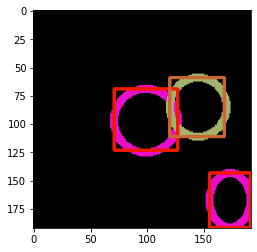

In [23]:
index_item = np.random.randint(len(dataset_ellipse))
imgs, labels, paths, _ = dataset_ellipse[index_item]
img = imgs.cpu().numpy().transpose(1,2,0)

imgs = imgs[None]
imgs = imgs.to(device, non_blocking=True).float() / 255.0  # uint8 to float32, 0-255 to 0.0-1.0
colors = np.array([[0.95,0.1,0.0],[0.8,0.4,0.2],[0.1,1.0,0.1]]) * 255
thickness=2
dim_img = np.array(list(reversed(img.shape[:2])))
for box in labels:
    pt1 = np.array(box[2:4] * dim_img,dtype=np.int32) 
    dims = np.array(box[4:6] * dim_img,dtype=np.int32)  
    pt2 = pt1 + dims//2
    pt1 = pt1 - dims//2
    c_point = colors[int(box[1])]
    img = cv2.rectangle(img.copy(),pt1.tolist(),pt2.tolist(),color=c_point,thickness=thickness)

plt.imshow(img)


In [ ]:
ts.setup_dataset(dataset_ellipse, dataloader_ellipse, dataloader_ellipse_test, imgsz)
ts.setup_training()
ts.train(opt)


### Evaluation

In [25]:
model = ts.model
model.eval()
model.half()
torch.cuda.empty_cache()
print("MODEL READY")




Overriding model.yaml nc=1 with nc=3

                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1      7040  models.common.Conv                      [12, 64, 3, 1]                
  2                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  3                -1  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  4                -2  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                

MODEL READY


torch.Size([1, 3, 192, 192])


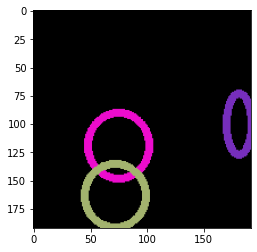

In [34]:
imgs, labels, paths, _ = dataset_ellipse[0]
img = imgs.cpu().numpy().transpose(1,2,0)
imgs = imgs[None].to(device, non_blocking=True).float() / 255.0  # uint8 to float32, 0-255 to 0.0-1.0
print(imgs.size())
with torch.no_grad():
    out = model(imgs.half())


plt.imshow(img)
# plt.grid()

In [35]:

iou_thres = 0.5
conf_threshold = 0.3
nms_outputs = non_max_suppression(out[0].detach(), conf_thres=conf_threshold, iou_thres=iou_thres,)[0]
print(nms_outputs)
predictions = nms_outputs.cpu().numpy()
colors = np.array([[0.95,0.1,0.0],[0.8,0.4,0.2],[0.1,1.0,0.1]]) * 255
thickness=6
for pred in predictions:
    pt1 = np.asarray(pred[:2],dtype=np.int32) 
    pt2 = np.asarray(pred[2:4],dtype=np.int32)  
    c_point = colors[int(pred[5])]
    img = cv2.rectangle(img.copy(),pt1.tolist(),pt2.tolist(),color=c_point,thickness=thickness)

plt.imshow(img)





In [37]:
del ts, dataloader_ellipse, dataset_ellipse, dataloader_ellipse_test, imgsz

## Real Problem: Car detection

In [38]:
opt.data = 'data/vehicle.yaml'
opt.cfg = 'cfg/training/yolov7-vehicle.yaml'
opt.hyp = 'data/hyp.scratch.custom.yaml'
opt.project = 'train_car_detection'
opt.data, opt.cfg, opt.hyp = check_file(opt.data), check_file(opt.cfg), check_file(opt.hyp)  # check files
assert len(opt.cfg) or len(opt.weights), 'either --cfg or --weights must be specified'
opt.name = 'yolov7-6e'
opt.save_dir = 'runs'
##### Dataset info ####################################
opt.update_dataset = True
opt.data_train ='../archive/data/images' # 
opt.names_classes = ['vehicle'] 
opt.nc = 1
opt.single_cls = True

##### HYPER-PARAMS OPTIMIZATION ########################
opt.weights = ''# '/home/luis/2022/yolov7/weights/yolov7-e6_training.pt'
opt.batch_size = 8
opt.device = 'cuda' if torch.cuda.is_available() else 'cpu'
opt.multi_scale = False
opt.epochs = 30
opt.img_size = [480, 480]
opt.img_size.extend([opt.img_size[-1]] * (2 - len(opt.img_size)))  # extend to 2 sizes (train, test)
opt.adam = True
opt.accumulate = 2

In [ ]:
ts = training_session(hyp, opt, device)
max_stride = ts.max_stride
data_dict = ts.data_dict
dataset_train, dataloader_train,dataloader_test, imgsz = get_files_datasets(hyp, opt, ts.data_dict, max_stride)

In [22]:
ts.setup_dataset(dataset_train, dataloader_train, dataloader_test, imgsz)
ts.setup_training()
ts.train(opt)

Image sizes 512 train, 512 test
Using 3 dataloader workers
Logging results to runs
Starting training for 50 epochs...

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
      0/49     6.08G   0.02683  0.004061         0   0.03089         1       512


autoanchor: Analyzing anchors... anchors/target = 4.02, Best Possible Recall (BPR) = 1.0000


      0/49     6.16G   0.02407 0.0001727         0   0.02424         1       512
               Class      Images      Labels           P           R      mAP@.5


                 all        1001           0           0           0           0           0



     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
      1/49     6.16G   0.02509 8.522e-05         0   0.02517         1       512
               Class      Images      Labels           P           R      mAP@.5


                 all        1001           0           0           0           0           0



     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
      2/49     6.16G   0.02367 0.0001112         0   0.02378         1       512
               Class      Images      Labels           P           R      mAP@.5


                 all        1001           0           0           0           0           0



     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
      3/49     6.16G    0.0226 0.0001414         0   0.02274         1       512
               Class      Images      Labels           P           R      mAP@.5


KeyboardInterrupt: 

### Evaluation

In [57]:
import pandas as pd 

file = 'runs/results.txt'

column_names = ["epoch","MEM","Loss BBox","Loss Obj.","Loss Class","Total Loss","Process Number",
                "Size Img","P","R","AP 0.5","mAP@0.5:0.95","VAL Loss BBox", 'VAL Loss Obj.','VAL Loss CLS']
data = np.loadtxt(file,dtype=str)
data = pd.DataFrame(data,columns = column_names)

for name in ["Loss BBox","Loss Obj.","Loss Class","Total Loss","P","R","AP 0.5","mAP@0.5:0.95","VAL Loss BBox", 'VAL Loss Obj.','VAL Loss CLS']:
    data[name] = data[name].astype('float32')
print('data shape: ',data.shape)
data.sample(5)

(26, 15)
N columns:  15
['epoch', 'MEM', 'Loss BBox', 'Loss Obj.', 'Loss Class', 'Total Loss', 'Process Number', 'Size Img', 'P', 'R', 'AP 0.5', 'mAP@0.5:0.95', 'VAL Loss BBox', 'VAL Loss Obj.', 'VAL Loss CLS']
['0/49' '4.43G' '0.02323' '0.0005522' '0' '0.02379' '1' '512' '0' '0' '0' '0' '0' '0' '0']
n rows:  26
Loss BBox
Loss Obj.
Loss Class
Total Loss
P
R
AP 0.5
mAP@0.5:0.95
VAL Loss BBox
VAL Loss Obj.
VAL Loss CLS
data shape:  (26, 15)


,epoch,MEM,Loss BBox,Loss Obj.,Loss Class,...,AP 0.5,mAP@0.5:0.95,VAL Loss BBox,VAL Loss Obj.,VAL Loss CLS
9,9/49,4.51G,0.02613,0.000411,0.0,...,0.0,0.0,0.0,0.0,0.0
0,0/49,4.43G,0.02323,0.000552,0.0,...,0.0,0.0,0.0,0.0,0.0
13,13/49,4.51G,0.02358,0.000551,0.0,...,0.0,0.0,0.0,0.0,0.0
23,23/49,4.51G,0.02179,0.000494,0.0,...,0.0,0.0,0.0,0.0,0.0
4,4/49,4.51G,0.02713,0.000473,0.0,...,0.0,0.0,0.0,0.0,0.0


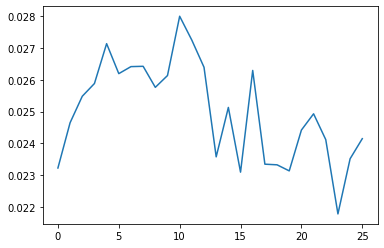

In [60]:
plt.plot(data.index,data['Loss BBox'])

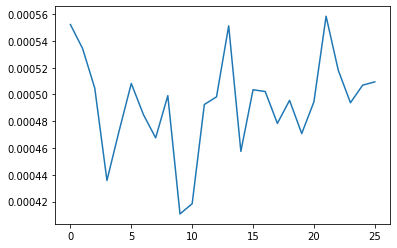

In [61]:
plt.plot(data.index,data['Loss Obj.'])

### Testing

In [40]:
torch.cuda.empty_cache()

In [ ]:
model = ts.model
model.eval()
model.half()
print("MODEL READY")

# import collections 
# ### OPTIONAL ###
# def load_pretrained(weights,opt,device,nc,strict=False):
#     ckpt = torch.load(weights, map_location=device)  # load checkpoint
#     model = Model(opt.cfg or ckpt['model'].yaml, ch=3, nc=nc, anchors=hyp.get('anchors')).to(
#         device)  # create
#     exclude = []  
#     if type(ckpt['model'])==collections.OrderedDict:
#         state_dict = ckpt['model']  # to FP32
#     else:
#         state_dict = ckpt['model'].float().state_dict()  # to FP32
#     state_dict = intersect_dicts(state_dict, model.state_dict())  # intersect
#     model.load_state_dict(state_dict, strict=strict)  # load
#     return model


# model = load_pretrained('/home/luis/2024/Hands_on/yolov7/runs_ellipse/weights/last.pt',opt,device,opt.nc,
#                        strict=True)
# model.eval()
# model.half()
# print("MODEL READY")

torch.Size([1, 3, 320, 512])


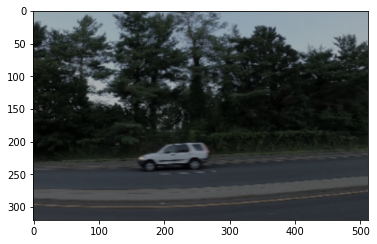

In [31]:

imgs, labels, paths, _ = dataloader_test.dataset[160]
img = imgs.cpu().numpy().transpose(1,2,0)
imgs = imgs[None].to(device, non_blocking=True).float() / 255.0  # uint8 to float32, 0-255 to 0.0-1.0
print(imgs.size())
with torch.no_grad():
    out = model(imgs.half())

plt.imshow(img)


tensor([[147.00000, 199.75000, 280.75000, 251.50000,   0.37012,   0.00000]], device='cuda:0')
tensor([[147.00000, 199.75000, 280.75000, 251.50000,   0.37012,   0.00000]], device='cuda:0')


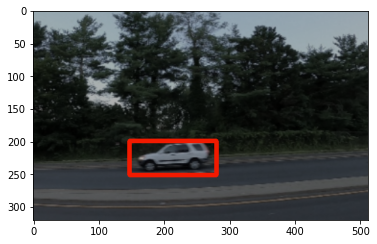

In [32]:

iou_thres = 0.5
conf_threshold = 0.01
nms_outputs = non_max_suppression(out[0].detach(), conf_thres=conf_threshold, iou_thres=iou_thres,)[0]
print(nms_outputs)
predictions = nms_outputs.cpu().numpy()
colors = np.array([[0.95,0.1,0.0],[0.8,0.4,0.2],[0.1,1.0,0.1]]) * 255
thickness=6
for pred in predictions:
    pt1 = np.asarray(pred[:2],dtype=np.int32) 
    pt2 = np.asarray(pred[2:4],dtype=np.int32)  
    c_point = colors[int(pred[5])]
    img = cv2.rectangle(img.copy(),pt1.tolist(),pt2.tolist(),color=c_point,thickness=thickness)

plt.imshow(img)
# plt.grid()
print(nms_outputs)


